In [1]:
from sklearn.metrics import accuracy_score
from support_function.read_data import *
from sklearn.model_selection import train_test_split
from support_function.reporting import reporting
from support_function.evaluate import *
from support_function.labeling_from_score import labeling

In [2]:
df_normalized = read_cleaned_data()

In [3]:
X = np.array(df_normalized[
    [
        "totalAsset",
        "averageTotalAsset",
        "frequencyMountOfTransaction",
        "borrow_per_balance",
        "deposit_per_asset",
        "borrow_per_deposit",
        "totalValueOfLiquidation",
        "numberOfLiquidation",
        "frequencyOfTransaction",
        "frequencyOfDappTransactions",
        "numberOfInteractedDapps",
        "typesOfInteractedDapps",
        "numberOfReputableDapps",
        "age",
    ]
].values)
first_y = df_normalized["1st_label"].values
second_y = df_normalized["2nd_label"].values

X_train, X_test, first_y_train, first_y_test, second_y_train, second_y_test = train_test_split(
    X, first_y, second_y, stratify=first_y, test_size=0.2, random_state=40
)

In [4]:
def new_error_func(first_y, second_y, y_pred):
    errors = [0] * len(y_pred)
    for i in range(len(y_pred)):
        if first_y[i] == second_y[i]:
            errors[i] = y_pred[i] - first_y[i]
        else:
            min_value = min(first_y[i], second_y[i])
            max_value = max(first_y[i], second_y[i])
            if y_pred[i] <= min_value:
                errors[i] = y_pred[i] - min_value
            if y_pred[i] >= max_value:
                errors[i] = y_pred[i] - max_value
    return errors


# Hàm tính gradient của hàm lỗi (MSE)
def gradient_mean_squared_error(X, y, second_y, w):
    n = len(y)
    y_pred = labeling(np.dot(X, w))
    # error = y_pred - y
    error = new_error_func(y, second_y, y_pred)
    gradient = 2 * np.dot(X.T, error) / n
    return gradient


# Gradient descent để tối ưu hóa hàm lỗi (MSE)
def adam(
    X,
    y,
    second_y,
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    num_iterations=10000,
):
    # Khởi tạo vector trọng số ngẫu nhiên
    w = np.random.uniform(0, 1, X.shape[1])
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    t = 0

    for _ in range(num_iterations):
        random_index = np.random.randint(0, len(X))
        X_sample = X[random_index : random_index + 1]
        y_sample = y[random_index : random_index + 1]
        second_y_sample = second_y[random_index : random_index + 1]

        # Tính gradient của hàm lỗi cho mẫu đã chọn
        grad = gradient_mean_squared_error(X_sample, y_sample, second_y_sample, w)

        # Tính trung bình độ lớn của gradient và gradient bình phương
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad**2)

        # Bias correction
        m_hat = m / (1 - beta1 ** (t + 1))
        v_hat = v / (1 - beta2 ** (t + 1))

        w -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        t += 1

    return w

In [5]:
learned_weights = adam(X_train, first_y_train, second_y_train)

In [6]:
predicted_labels = labeling(X_test.dot(learned_weights))
print(new_accuracy(first_y_test, second_y_test, predicted_labels))

0.91701244813278


In [7]:
print(precision(first_y_test, second_y_test, predicted_labels))

0.8236583051020763


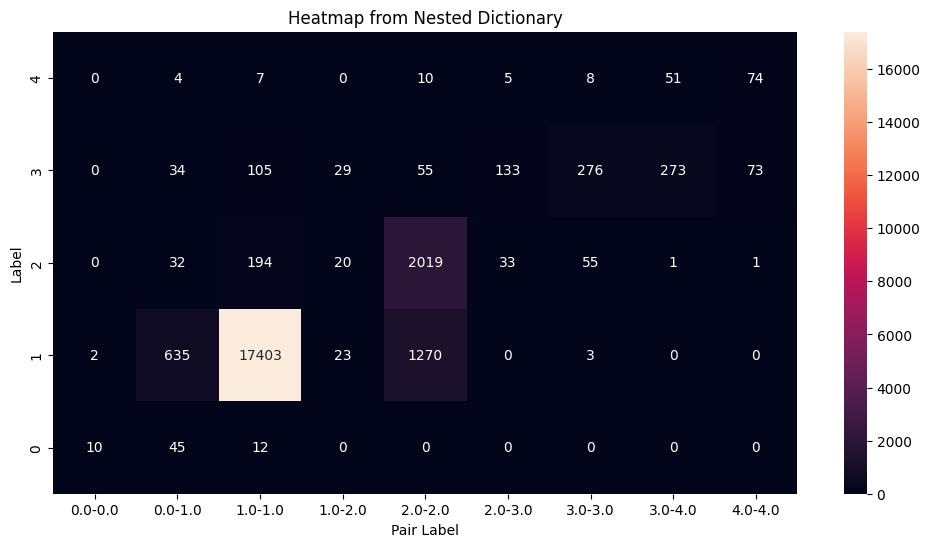

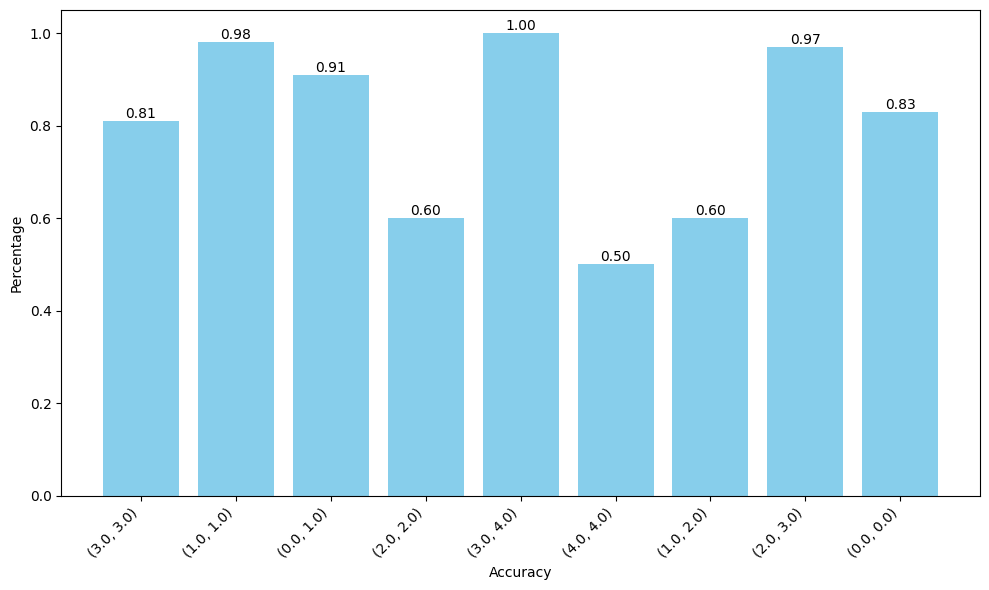

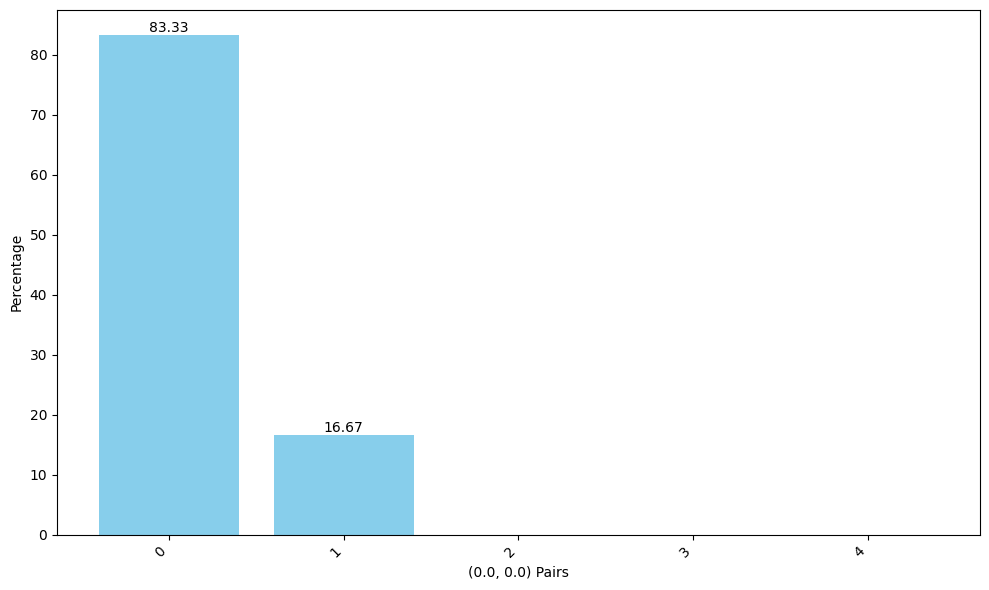

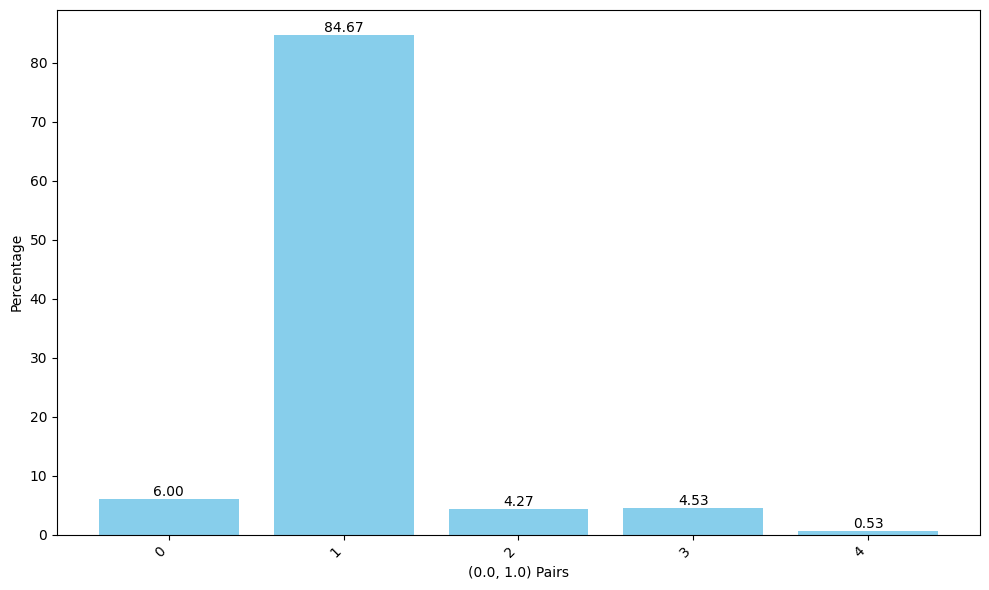

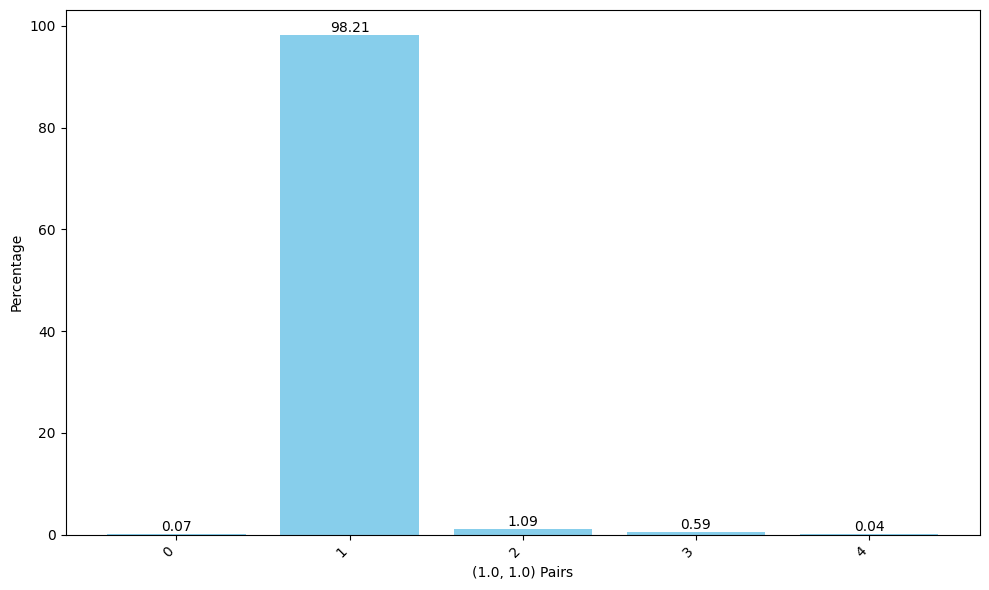

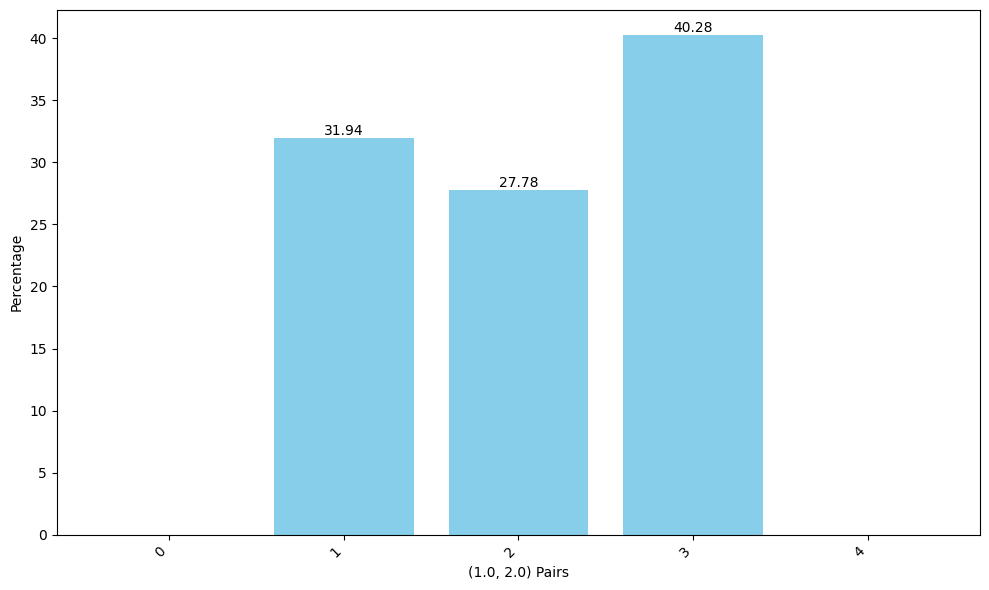

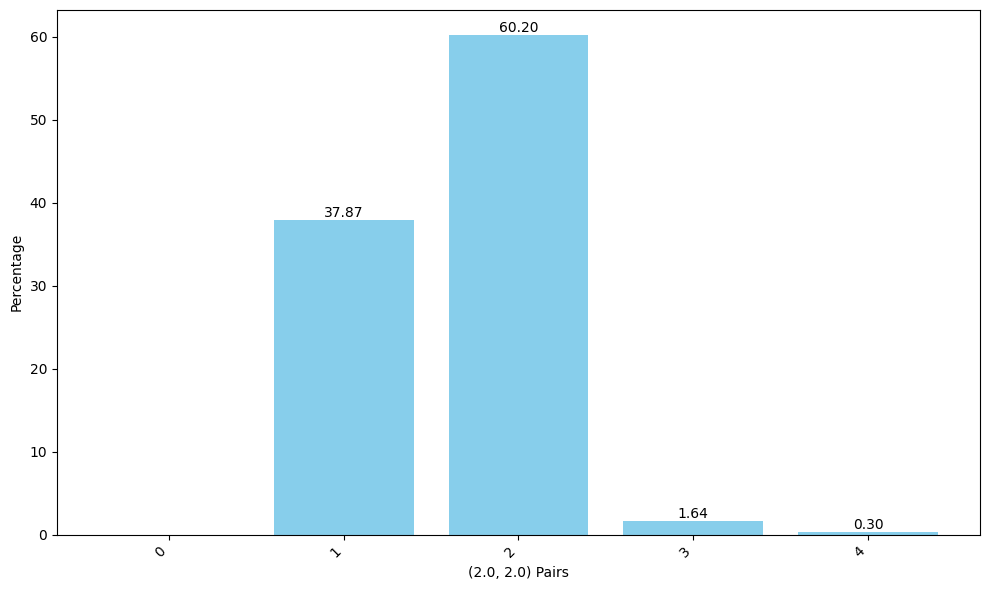

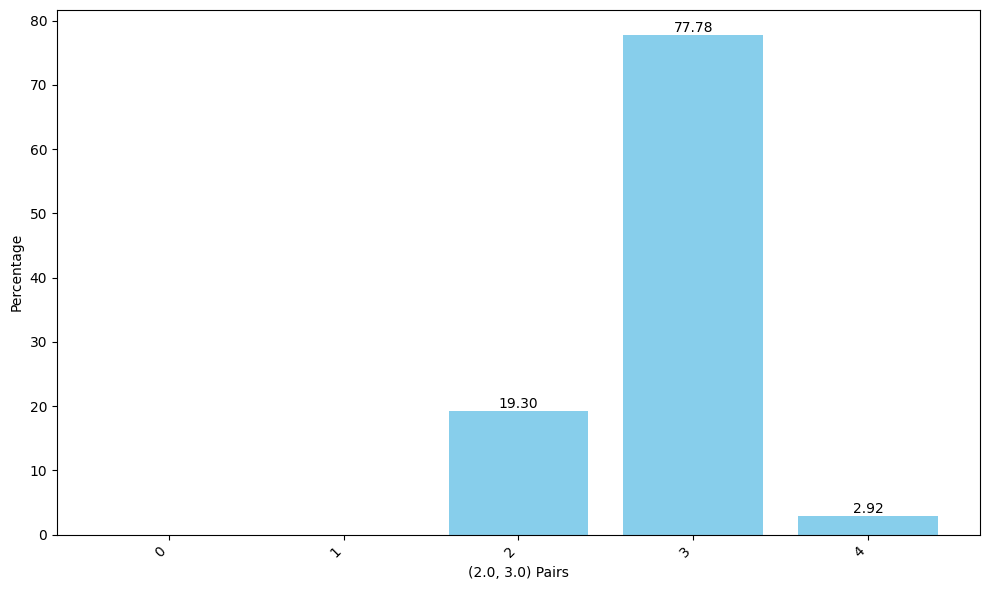

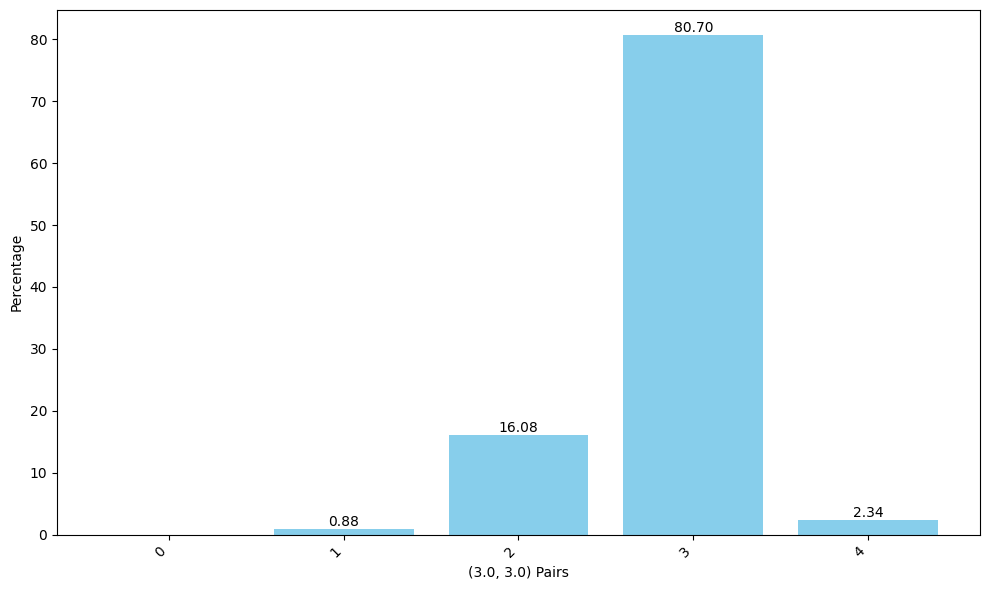

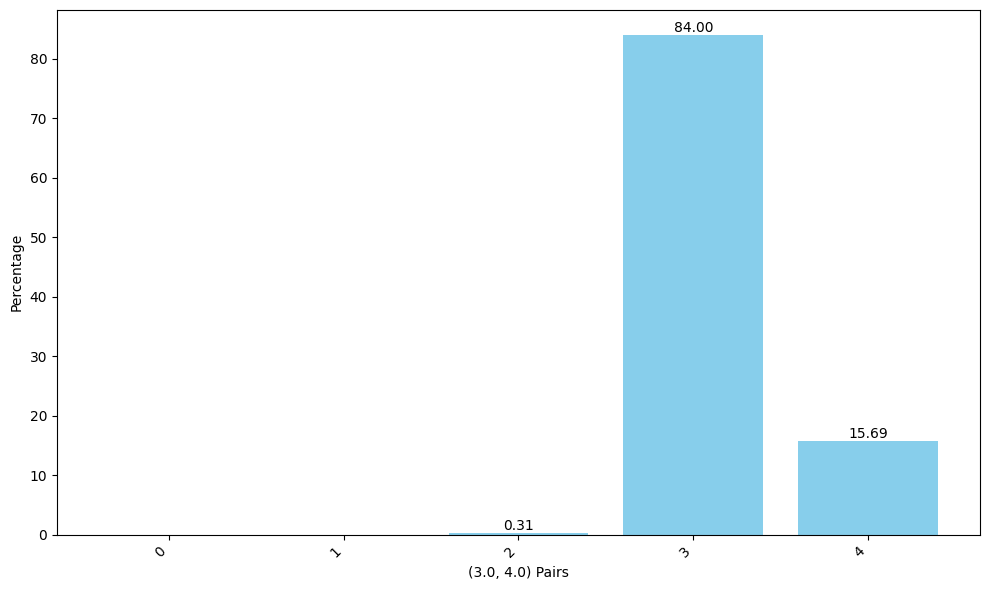

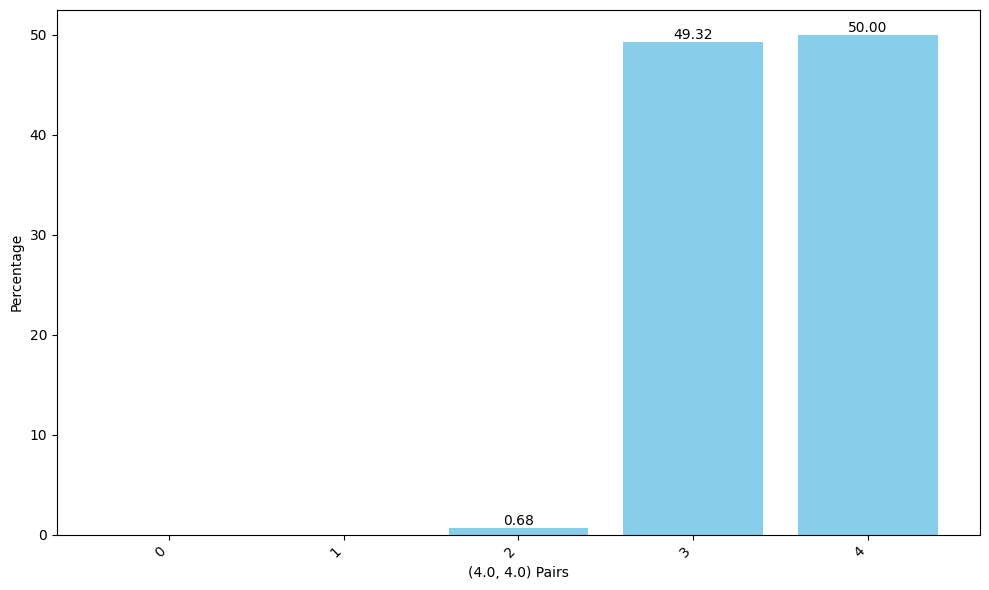

In [8]:
reporting(first_y_test, second_y_test, predicted_labels)